In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.num_parameters = self.count_params(layers, grid_size)
        self.layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [4]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t      Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [ ]:
def build_data_frame(model, num_epochs, train_losses, val_losses, train_accs, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [5]:
# Define models and parameters

model_list_mlp = [
    MyMLP([28*28, 128, 10]),
    MyMLP([28*28, 64, 10]),
    MyMLP([28*28, 10, 10]),
    MyMLP([28*28, 10, 10, 10]),
    MyMLP([28*28, 5, 5, 10])
    ]
model_list_kan = [
    MyKAN([28*28, 64, 10], grid_size=3),
    MyKAN([28*28, 10, 10], grid_size=3),
    MyKAN([28*28, 5, 10], grid_size=3),
    MyKAN([28*28, 10, 10, 10], grid_size=3),
    MyKAN([28*28, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_mlp],
        'Loss (v)': [i for i in val_losses_mlp],
        'Accuracy (t)': [i for i in train_accs_mlp],
        'Accuracy (v)': [i for i in val_accs_mlp],
        'Time': [i for i in time_mlp]
        })

    single_df_kan = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_kan],
        'Loss (v)': [i for i in val_losses_kan],
        'Accuracy (t)': [i for i in train_accs_kan],
        'Accuracy (v)': [i for i in val_accs_kan],
        'Time': [i for i in time_kan]
        })

    means_mlp = {'Epoch': 'Mean', 'Time': single_df_mlp['Time'].mean()}
    means_kan = {'Epoch': 'Mean', 'Time': single_df_kan['Time'].mean()}

    num_params_mlp = {'Epoch': f'Params: {model_mlp.num_parameters}'}
    num_params_kan = {'Epoch': f'Params: {model_kan.num_parameters}'}

    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([means_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([num_params_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, separator], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([means_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([num_params_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, separator], ignore_index=True)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 101770



100%|██████████| 938/938 [00:07<00:00, 130.37it/s]


Epoch [1/10], Train Loss: 0.3824, Train Accuracy: 0.8901, Time: 7.20s
	      Valid Loss: 0.2365, Valid Accuracy: 0.9380



100%|██████████| 938/938 [00:06<00:00, 144.69it/s]


Epoch [2/10], Train Loss: 0.1986, Train Accuracy: 0.9425, Time: 6.48s
	      Valid Loss: 0.1605, Valid Accuracy: 0.9583



100%|██████████| 938/938 [00:06<00:00, 144.05it/s]


Epoch [3/10], Train Loss: 0.1458, Train Accuracy: 0.9577, Time: 6.51s
	      Valid Loss: 0.1402, Valid Accuracy: 0.9629



100%|██████████| 938/938 [00:06<00:00, 150.02it/s]


Epoch [4/10], Train Loss: 0.1183, Train Accuracy: 0.9658, Time: 6.25s
	      Valid Loss: 0.1363, Valid Accuracy: 0.9656



100%|██████████| 938/938 [00:06<00:00, 145.72it/s]


Epoch [5/10], Train Loss: 0.1001, Train Accuracy: 0.9708, Time: 6.44s
	      Valid Loss: 0.1165, Valid Accuracy: 0.9688



100%|██████████| 938/938 [00:06<00:00, 148.14it/s]


Epoch [6/10], Train Loss: 0.0874, Train Accuracy: 0.9747, Time: 6.33s
	      Valid Loss: 0.1022, Valid Accuracy: 0.9753



100%|██████████| 938/938 [00:06<00:00, 141.81it/s]


Epoch [7/10], Train Loss: 0.0766, Train Accuracy: 0.9774, Time: 6.62s
	      Valid Loss: 0.1006, Valid Accuracy: 0.9755



100%|██████████| 938/938 [00:06<00:00, 147.76it/s]


Epoch [8/10], Train Loss: 0.0724, Train Accuracy: 0.9784, Time: 6.35s
	      Valid Loss: 0.0995, Valid Accuracy: 0.9764



100%|██████████| 938/938 [00:06<00:00, 142.39it/s]


Epoch [9/10], Train Loss: 0.0641, Train Accuracy: 0.9806, Time: 6.59s
	      Valid Loss: 0.1054, Valid Accuracy: 0.9749



100%|██████████| 938/938 [00:06<00:00, 145.40it/s]


Epoch [10/10], Train Loss: 0.0611, Train Accuracy: 0.9818, Time: 6.45s
	      Valid Loss: 0.0842, Valid Accuracy: 0.9827

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 152448



100%|██████████| 938/938 [00:07<00:00, 122.41it/s]


Epoch [1/10], Train Loss: 0.3997, Train Accuracy: 0.8874, Time: 7.66s
	      Valid Loss: 0.2366, Valid Accuracy: 0.9390



100%|██████████| 938/938 [00:07<00:00, 127.77it/s]


Epoch [2/10], Train Loss: 0.1902, Train Accuracy: 0.9469, Time: 7.34s
	      Valid Loss: 0.1507, Valid Accuracy: 0.9587



100%|██████████| 938/938 [00:07<00:00, 125.52it/s]


Epoch [3/10], Train Loss: 0.1273, Train Accuracy: 0.9637, Time: 7.47s
	      Valid Loss: 0.1204, Valid Accuracy: 0.9703



100%|██████████| 938/938 [00:07<00:00, 126.03it/s]


Epoch [4/10], Train Loss: 0.0949, Train Accuracy: 0.9731, Time: 7.44s
	      Valid Loss: 0.0994, Valid Accuracy: 0.9751



100%|██████████| 938/938 [00:07<00:00, 126.84it/s]


Epoch [5/10], Train Loss: 0.0731, Train Accuracy: 0.9789, Time: 7.40s
	      Valid Loss: 0.0942, Valid Accuracy: 0.9779



100%|██████████| 938/938 [00:07<00:00, 122.69it/s]


Epoch [6/10], Train Loss: 0.0589, Train Accuracy: 0.9835, Time: 7.65s
	      Valid Loss: 0.0938, Valid Accuracy: 0.9768



100%|██████████| 938/938 [00:07<00:00, 124.90it/s]


Epoch [7/10], Train Loss: 0.0468, Train Accuracy: 0.9875, Time: 7.51s
	      Valid Loss: 0.0907, Valid Accuracy: 0.9789



100%|██████████| 938/938 [00:07<00:00, 127.10it/s]


Epoch [8/10], Train Loss: 0.0371, Train Accuracy: 0.9903, Time: 7.38s
	      Valid Loss: 0.0908, Valid Accuracy: 0.9778



100%|██████████| 938/938 [00:08<00:00, 116.23it/s]


Epoch [9/10], Train Loss: 0.0306, Train Accuracy: 0.9921, Time: 8.07s
	      Valid Loss: 0.0854, Valid Accuracy: 0.9801



100%|██████████| 938/938 [00:07<00:00, 118.43it/s]


Epoch [10/10], Train Loss: 0.0264, Train Accuracy: 0.9929, Time: 7.92s
	      Valid Loss: 0.0867, Valid Accuracy: 0.9797

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 50890



100%|██████████| 938/938 [00:06<00:00, 142.15it/s]


Epoch [1/10], Train Loss: 0.4391, Train Accuracy: 0.8767, Time: 6.60s
	      Valid Loss: 0.2793, Valid Accuracy: 0.9263



100%|██████████| 938/938 [00:06<00:00, 144.98it/s]


Epoch [2/10], Train Loss: 0.2528, Train Accuracy: 0.9272, Time: 6.47s
	      Valid Loss: 0.2103, Valid Accuracy: 0.9436



100%|██████████| 938/938 [00:06<00:00, 151.97it/s]


Epoch [3/10], Train Loss: 0.1939, Train Accuracy: 0.9441, Time: 6.17s
	      Valid Loss: 0.1797, Valid Accuracy: 0.9527



100%|██████████| 938/938 [00:06<00:00, 150.40it/s]


Epoch [4/10], Train Loss: 0.1584, Train Accuracy: 0.9543, Time: 6.24s
	      Valid Loss: 0.1540, Valid Accuracy: 0.9619



100%|██████████| 938/938 [00:06<00:00, 146.36it/s]


Epoch [5/10], Train Loss: 0.1345, Train Accuracy: 0.9612, Time: 6.41s
	      Valid Loss: 0.1264, Valid Accuracy: 0.9675



100%|██████████| 938/938 [00:06<00:00, 148.20it/s]


Epoch [6/10], Train Loss: 0.1228, Train Accuracy: 0.9641, Time: 6.33s
	      Valid Loss: 0.1246, Valid Accuracy: 0.9691



100%|██████████| 938/938 [00:06<00:00, 145.28it/s]


Epoch [7/10], Train Loss: 0.1109, Train Accuracy: 0.9673, Time: 6.46s
	      Valid Loss: 0.1214, Valid Accuracy: 0.9703



100%|██████████| 938/938 [00:06<00:00, 144.69it/s]


Epoch [8/10], Train Loss: 0.1007, Train Accuracy: 0.9704, Time: 6.48s
	      Valid Loss: 0.1233, Valid Accuracy: 0.9719



100%|██████████| 938/938 [00:06<00:00, 148.80it/s]


Epoch [9/10], Train Loss: 0.0944, Train Accuracy: 0.9714, Time: 6.30s
	      Valid Loss: 0.1069, Valid Accuracy: 0.9771



100%|██████████| 938/938 [00:06<00:00, 147.95it/s]


Epoch [10/10], Train Loss: 0.0898, Train Accuracy: 0.9727, Time: 6.34s
	      Valid Loss: 0.1107, Valid Accuracy: 0.9743

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 23820



100%|██████████| 938/938 [00:07<00:00, 124.91it/s]


Epoch [1/10], Train Loss: 0.5613, Train Accuracy: 0.8417, Time: 7.51s
	      Valid Loss: 0.3169, Valid Accuracy: 0.9168



100%|██████████| 938/938 [00:07<00:00, 124.03it/s]


Epoch [2/10], Train Loss: 0.2944, Train Accuracy: 0.9169, Time: 7.56s
	      Valid Loss: 0.2709, Valid Accuracy: 0.9254



100%|██████████| 938/938 [00:07<00:00, 121.19it/s]


Epoch [3/10], Train Loss: 0.2566, Train Accuracy: 0.9276, Time: 7.74s
	      Valid Loss: 0.2611, Valid Accuracy: 0.9333



100%|██████████| 938/938 [00:07<00:00, 120.71it/s]


Epoch [4/10], Train Loss: 0.2332, Train Accuracy: 0.9350, Time: 7.77s
	      Valid Loss: 0.2390, Valid Accuracy: 0.9384



100%|██████████| 938/938 [00:07<00:00, 121.89it/s]


Epoch [5/10], Train Loss: 0.2167, Train Accuracy: 0.9394, Time: 7.70s
	      Valid Loss: 0.2256, Valid Accuracy: 0.9433



100%|██████████| 938/938 [00:07<00:00, 122.55it/s]


Epoch [6/10], Train Loss: 0.2031, Train Accuracy: 0.9428, Time: 7.66s
	      Valid Loss: 0.2220, Valid Accuracy: 0.9416



100%|██████████| 938/938 [00:07<00:00, 124.06it/s]


Epoch [7/10], Train Loss: 0.1925, Train Accuracy: 0.9459, Time: 7.56s
	      Valid Loss: 0.2253, Valid Accuracy: 0.9440



100%|██████████| 938/938 [00:07<00:00, 120.55it/s]


Epoch [8/10], Train Loss: 0.1845, Train Accuracy: 0.9482, Time: 7.78s
	      Valid Loss: 0.2209, Valid Accuracy: 0.9450



100%|██████████| 938/938 [00:07<00:00, 123.73it/s]


Epoch [9/10], Train Loss: 0.1774, Train Accuracy: 0.9501, Time: 7.58s
	      Valid Loss: 0.2099, Valid Accuracy: 0.9491



100%|██████████| 938/938 [00:07<00:00, 119.56it/s]


Epoch [10/10], Train Loss: 0.1709, Train Accuracy: 0.9520, Time: 7.85s
	      Valid Loss: 0.2128, Valid Accuracy: 0.9483

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 7960



100%|██████████| 938/938 [00:06<00:00, 140.76it/s]


Epoch [1/10], Train Loss: 1.0439, Train Accuracy: 0.6581, Time: 6.67s
	      Valid Loss: 0.7480, Valid Accuracy: 0.7788



100%|██████████| 938/938 [00:06<00:00, 139.16it/s]


Epoch [2/10], Train Loss: 0.6804, Train Accuracy: 0.7990, Time: 6.74s
	      Valid Loss: 0.6076, Valid Accuracy: 0.8294



100%|██████████| 938/938 [00:06<00:00, 141.56it/s]


Epoch [3/10], Train Loss: 0.6011, Train Accuracy: 0.8242, Time: 6.63s
	      Valid Loss: 0.5910, Valid Accuracy: 0.8268



100%|██████████| 938/938 [00:06<00:00, 145.19it/s]


Epoch [4/10], Train Loss: 0.5674, Train Accuracy: 0.8317, Time: 6.46s
	      Valid Loss: 0.5381, Valid Accuracy: 0.8468



100%|██████████| 938/938 [00:06<00:00, 143.25it/s]


Epoch [5/10], Train Loss: 0.5482, Train Accuracy: 0.8385, Time: 6.55s
	      Valid Loss: 0.5420, Valid Accuracy: 0.8412



100%|██████████| 938/938 [00:06<00:00, 148.56it/s]


Epoch [6/10], Train Loss: 0.5348, Train Accuracy: 0.8436, Time: 6.32s
	      Valid Loss: 0.5149, Valid Accuracy: 0.8533



100%|██████████| 938/938 [00:06<00:00, 141.49it/s]


Epoch [7/10], Train Loss: 0.5249, Train Accuracy: 0.8465, Time: 6.63s
	      Valid Loss: 0.5093, Valid Accuracy: 0.8558



100%|██████████| 938/938 [00:06<00:00, 143.17it/s]


Epoch [8/10], Train Loss: 0.5148, Train Accuracy: 0.8501, Time: 6.55s
	      Valid Loss: 0.5139, Valid Accuracy: 0.8567



100%|██████████| 938/938 [00:06<00:00, 144.41it/s]


Epoch [9/10], Train Loss: 0.5084, Train Accuracy: 0.8522, Time: 6.50s
	      Valid Loss: 0.5249, Valid Accuracy: 0.8450



100%|██████████| 938/938 [00:06<00:00, 141.96it/s]


Epoch [10/10], Train Loss: 0.4998, Train Accuracy: 0.8559, Time: 6.61s
	      Valid Loss: 0.4869, Valid Accuracy: 0.8648

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11910



100%|██████████| 938/938 [00:07<00:00, 118.72it/s]


Epoch [1/10], Train Loss: 0.9313, Train Accuracy: 0.7156, Time: 7.90s
	      Valid Loss: 0.5817, Valid Accuracy: 0.8364



100%|██████████| 938/938 [00:07<00:00, 125.05it/s]


Epoch [2/10], Train Loss: 0.5073, Train Accuracy: 0.8547, Time: 7.50s
	      Valid Loss: 0.4678, Valid Accuracy: 0.8679



100%|██████████| 938/938 [00:07<00:00, 123.87it/s]


Epoch [3/10], Train Loss: 0.4294, Train Accuracy: 0.8787, Time: 7.57s
	      Valid Loss: 0.4217, Valid Accuracy: 0.8828



100%|██████████| 938/938 [00:07<00:00, 122.47it/s]


Epoch [4/10], Train Loss: 0.3909, Train Accuracy: 0.8893, Time: 7.66s
	      Valid Loss: 0.3897, Valid Accuracy: 0.8954



100%|██████████| 938/938 [00:07<00:00, 125.71it/s]


Epoch [5/10], Train Loss: 0.3692, Train Accuracy: 0.8953, Time: 7.46s
	      Valid Loss: 0.3768, Valid Accuracy: 0.9016



100%|██████████| 938/938 [00:07<00:00, 123.47it/s]


Epoch [6/10], Train Loss: 0.3529, Train Accuracy: 0.8999, Time: 7.60s
	      Valid Loss: 0.3863, Valid Accuracy: 0.8915



100%|██████████| 938/938 [00:07<00:00, 120.55it/s]


Epoch [7/10], Train Loss: 0.3389, Train Accuracy: 0.9042, Time: 7.78s
	      Valid Loss: 0.3631, Valid Accuracy: 0.8994



100%|██████████| 938/938 [00:07<00:00, 121.43it/s]


Epoch [8/10], Train Loss: 0.3300, Train Accuracy: 0.9055, Time: 7.73s
	      Valid Loss: 0.3557, Valid Accuracy: 0.9026



100%|██████████| 938/938 [00:07<00:00, 122.46it/s]


Epoch [9/10], Train Loss: 0.3226, Train Accuracy: 0.9079, Time: 7.66s
	      Valid Loss: 0.3498, Valid Accuracy: 0.9078



100%|██████████| 938/938 [00:07<00:00, 124.23it/s]


Epoch [10/10], Train Loss: 0.3150, Train Accuracy: 0.9102, Time: 7.55s
	      Valid Loss: 0.3426, Valid Accuracy: 0.9114

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 8070



100%|██████████| 938/938 [00:06<00:00, 141.23it/s]


Epoch [1/10], Train Loss: 1.0206, Train Accuracy: 0.6624, Time: 6.64s
	      Valid Loss: 0.6584, Valid Accuracy: 0.8079



100%|██████████| 938/938 [00:06<00:00, 138.34it/s]


Epoch [2/10], Train Loss: 0.6026, Train Accuracy: 0.8243, Time: 6.78s
	      Valid Loss: 0.5493, Valid Accuracy: 0.8433



100%|██████████| 938/938 [00:06<00:00, 144.57it/s]


Epoch [3/10], Train Loss: 0.5147, Train Accuracy: 0.8500, Time: 6.49s
	      Valid Loss: 0.4652, Valid Accuracy: 0.8678



100%|██████████| 938/938 [00:06<00:00, 142.85it/s]


Epoch [4/10], Train Loss: 0.4355, Train Accuracy: 0.8739, Time: 6.57s
	      Valid Loss: 0.4223, Valid Accuracy: 0.8818



100%|██████████| 938/938 [00:06<00:00, 138.66it/s]


Epoch [5/10], Train Loss: 0.3911, Train Accuracy: 0.8871, Time: 6.77s
	      Valid Loss: 0.3768, Valid Accuracy: 0.8952



100%|██████████| 938/938 [00:06<00:00, 148.17it/s]


Epoch [6/10], Train Loss: 0.3690, Train Accuracy: 0.8941, Time: 6.33s
	      Valid Loss: 0.3575, Valid Accuracy: 0.8999



100%|██████████| 938/938 [00:06<00:00, 147.09it/s]


Epoch [7/10], Train Loss: 0.3573, Train Accuracy: 0.8978, Time: 6.38s
	      Valid Loss: 0.3429, Valid Accuracy: 0.9087



100%|██████████| 938/938 [00:06<00:00, 147.57it/s]


Epoch [8/10], Train Loss: 0.3486, Train Accuracy: 0.9005, Time: 6.36s
	      Valid Loss: 0.3395, Valid Accuracy: 0.9096



100%|██████████| 938/938 [00:06<00:00, 147.10it/s]


Epoch [9/10], Train Loss: 0.3405, Train Accuracy: 0.9022, Time: 6.38s
	      Valid Loss: 0.3297, Valid Accuracy: 0.9115



100%|██████████| 938/938 [00:06<00:00, 139.86it/s]


Epoch [10/10], Train Loss: 0.3321, Train Accuracy: 0.9059, Time: 6.71s
	      Valid Loss: 0.3276, Valid Accuracy: 0.9103

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 24120



100%|██████████| 938/938 [00:08<00:00, 109.90it/s]


Epoch [1/10], Train Loss: 0.6615, Train Accuracy: 0.8041, Time: 8.54s
	      Valid Loss: 0.3582, Valid Accuracy: 0.9052



100%|██████████| 938/938 [00:08<00:00, 108.54it/s]


Epoch [2/10], Train Loss: 0.3228, Train Accuracy: 0.9086, Time: 8.64s
	      Valid Loss: 0.2813, Valid Accuracy: 0.9275



100%|██████████| 938/938 [00:08<00:00, 108.28it/s]


Epoch [3/10], Train Loss: 0.2609, Train Accuracy: 0.9265, Time: 8.66s
	      Valid Loss: 0.2484, Valid Accuracy: 0.9372



100%|██████████| 938/938 [00:08<00:00, 109.59it/s]


Epoch [4/10], Train Loss: 0.2286, Train Accuracy: 0.9354, Time: 8.56s
	      Valid Loss: 0.2230, Valid Accuracy: 0.9420



100%|██████████| 938/938 [00:08<00:00, 110.93it/s]


Epoch [5/10], Train Loss: 0.2084, Train Accuracy: 0.9398, Time: 8.46s
	      Valid Loss: 0.2188, Valid Accuracy: 0.9420



100%|██████████| 938/938 [00:08<00:00, 108.75it/s]


Epoch [6/10], Train Loss: 0.1947, Train Accuracy: 0.9448, Time: 8.63s
	      Valid Loss: 0.2172, Valid Accuracy: 0.9434



100%|██████████| 938/938 [00:08<00:00, 108.43it/s]


Epoch [7/10], Train Loss: 0.1839, Train Accuracy: 0.9471, Time: 8.65s
	      Valid Loss: 0.2089, Valid Accuracy: 0.9450



100%|██████████| 938/938 [00:08<00:00, 112.19it/s]


Epoch [8/10], Train Loss: 0.1743, Train Accuracy: 0.9501, Time: 8.36s
	      Valid Loss: 0.2065, Valid Accuracy: 0.9449



100%|██████████| 938/938 [00:08<00:00, 106.19it/s]


Epoch [9/10], Train Loss: 0.1662, Train Accuracy: 0.9531, Time: 8.83s
	      Valid Loss: 0.2062, Valid Accuracy: 0.9450



100%|██████████| 938/938 [00:08<00:00, 112.29it/s]


Epoch [10/10], Train Loss: 0.1595, Train Accuracy: 0.9545, Time: 8.35s
	      Valid Loss: 0.2215, Valid Accuracy: 0.9401

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4015



100%|██████████| 938/938 [00:06<00:00, 143.19it/s]


Epoch [1/10], Train Loss: 1.5714, Train Accuracy: 0.4162, Time: 6.55s
	      Valid Loss: 1.2894, Valid Accuracy: 0.5420



100%|██████████| 938/938 [00:06<00:00, 139.85it/s]


Epoch [2/10], Train Loss: 1.1964, Train Accuracy: 0.5800, Time: 6.71s
	      Valid Loss: 1.1189, Valid Accuracy: 0.6248



100%|██████████| 938/938 [00:06<00:00, 147.74it/s]


Epoch [3/10], Train Loss: 1.0877, Train Accuracy: 0.6241, Time: 6.35s
	      Valid Loss: 1.0578, Valid Accuracy: 0.6418



100%|██████████| 938/938 [00:06<00:00, 141.99it/s]


Epoch [4/10], Train Loss: 1.0408, Train Accuracy: 0.6410, Time: 6.61s
	      Valid Loss: 1.0261, Valid Accuracy: 0.6541



100%|██████████| 938/938 [00:06<00:00, 139.89it/s]


Epoch [5/10], Train Loss: 1.0140, Train Accuracy: 0.6528, Time: 6.71s
	      Valid Loss: 1.0440, Valid Accuracy: 0.6433



100%|██████████| 938/938 [00:06<00:00, 139.56it/s]


Epoch [6/10], Train Loss: 0.9945, Train Accuracy: 0.6633, Time: 6.72s
	      Valid Loss: 0.9998, Valid Accuracy: 0.6738



100%|██████████| 938/938 [00:06<00:00, 139.67it/s]


Epoch [7/10], Train Loss: 0.9844, Train Accuracy: 0.6652, Time: 6.72s
	      Valid Loss: 1.0022, Valid Accuracy: 0.6614



100%|██████████| 938/938 [00:06<00:00, 145.50it/s]


Epoch [8/10], Train Loss: 0.9743, Train Accuracy: 0.6699, Time: 6.45s
	      Valid Loss: 1.0058, Valid Accuracy: 0.6675



100%|██████████| 938/938 [00:06<00:00, 149.01it/s]


Epoch [9/10], Train Loss: 0.9691, Train Accuracy: 0.6722, Time: 6.30s
	      Valid Loss: 0.9829, Valid Accuracy: 0.6748



100%|██████████| 938/938 [00:06<00:00, 145.40it/s]


Epoch [10/10], Train Loss: 0.9621, Train Accuracy: 0.6748, Time: 6.45s
	      Valid Loss: 0.9732, Valid Accuracy: 0.6786

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11985



100%|██████████| 938/938 [00:08<00:00, 109.17it/s]


Epoch [1/10], Train Loss: 1.1095, Train Accuracy: 0.6421, Time: 8.59s
	      Valid Loss: 0.7029, Valid Accuracy: 0.7780



100%|██████████| 938/938 [00:08<00:00, 109.90it/s]


Epoch [2/10], Train Loss: 0.5861, Train Accuracy: 0.8243, Time: 8.54s
	      Valid Loss: 0.5091, Valid Accuracy: 0.8560



100%|██████████| 938/938 [00:08<00:00, 109.74it/s]


Epoch [3/10], Train Loss: 0.4612, Train Accuracy: 0.8664, Time: 8.55s
	      Valid Loss: 0.4329, Valid Accuracy: 0.8765



100%|██████████| 938/938 [00:08<00:00, 109.39it/s]


Epoch [4/10], Train Loss: 0.4002, Train Accuracy: 0.8835, Time: 8.58s
	      Valid Loss: 0.3914, Valid Accuracy: 0.8923



100%|██████████| 938/938 [00:08<00:00, 109.72it/s]


Epoch [5/10], Train Loss: 0.3623, Train Accuracy: 0.8954, Time: 8.55s
	      Valid Loss: 0.3686, Valid Accuracy: 0.8972



100%|██████████| 938/938 [00:08<00:00, 111.55it/s]


Epoch [6/10], Train Loss: 0.3391, Train Accuracy: 0.9023, Time: 8.41s
	      Valid Loss: 0.3495, Valid Accuracy: 0.9054



100%|██████████| 938/938 [00:08<00:00, 110.08it/s]


Epoch [7/10], Train Loss: 0.3242, Train Accuracy: 0.9062, Time: 8.52s
	      Valid Loss: 0.3496, Valid Accuracy: 0.9028



100%|██████████| 938/938 [00:08<00:00, 109.38it/s]


Epoch [8/10], Train Loss: 0.3108, Train Accuracy: 0.9106, Time: 8.58s
	      Valid Loss: 0.3319, Valid Accuracy: 0.9118



100%|██████████| 938/938 [00:08<00:00, 109.76it/s]


Epoch [9/10], Train Loss: 0.3009, Train Accuracy: 0.9128, Time: 8.55s
	      Valid Loss: 0.3305, Valid Accuracy: 0.9093



100%|██████████| 938/938 [00:08<00:00, 106.50it/s]


Epoch [10/10], Train Loss: 0.2943, Train Accuracy: 0.9151, Time: 8.81s
	      Valid Loss: 0.3193, Valid Accuracy: 0.9140



In [6]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_8626/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


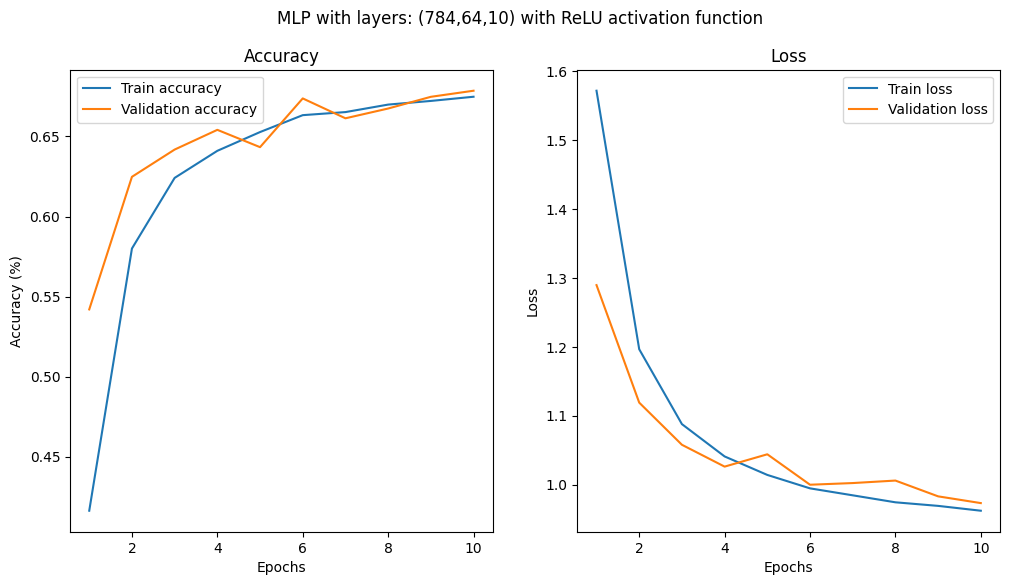

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_8626/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


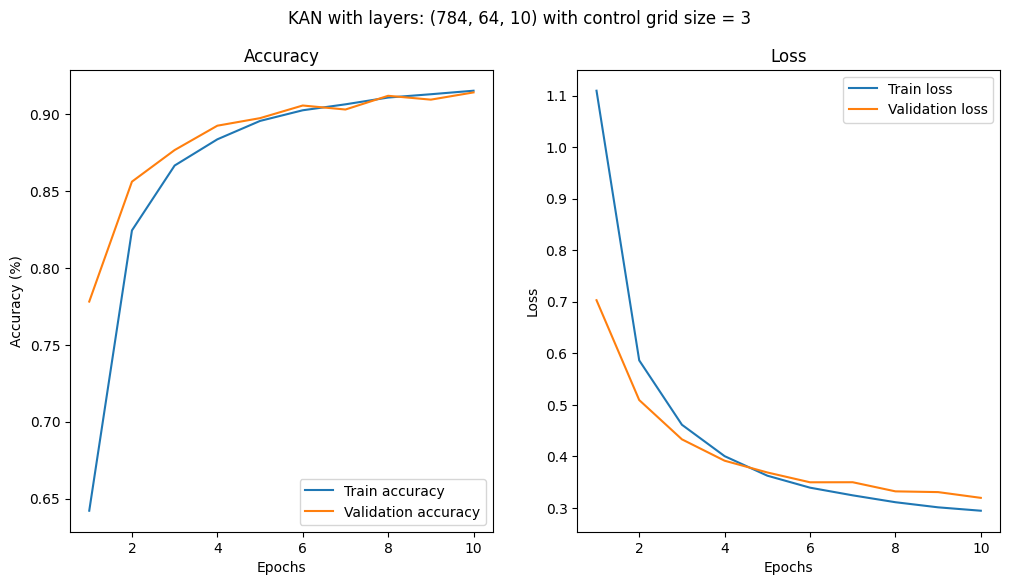

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()